# **Hands On Graph Neural Networks Using Python  -  CHAPTER 14**

- This code defines and trains two graph neural network (GNN) models: a GIN model and a GCN model, using PyTorch Geometric and Captum.

  - The `DataPreparation` class handles dataset loading and splitting for training, validation, and testing.

  - The `GINModel` class implements a Graph Isomorphism Network with three GINConv layers followed by linear layers for classification.

  - The `GCNModel` class implements a Graph Convolutional Network with two GCNConv layers.

  - The `ModelTrainer` class manages the training and evaluation process, including computing loss and accuracy.

  - After training the GIN model, the GNNExplainer is used to visualize feature importance on a sample graph. The GCN model is also trained on a Twitch dataset, and its accuracy is computed.

- The code includes dataset loading, model training, evaluation, and explanation with visualization.

In [2]:
!pip install -q torch-scatter~=2.1.0 torch-sparse~=0.6.16 torch-cluster~=1.6.0 torch-spline-conv~=1.2.1 torch-geometric~=2.0.4 -f https://data.pyg.org/whl/torch-{torch.__version__}.html
!pip install -q captum==0.6.0

!pip install -q torch-scatter~=2.1.0 torch-sparse~=0.6.16 torch-cluster~=1.6.0 torch-spline-conv~=1.2.1 torch-geometric~=2.0.4 -f https://data.pyg.org/whl/torch-{torch.__version__}.html
!pip install -q captum==0.6.0

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.9/10.9 MB 60.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.1/5.1 MB 85.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.4/3.4 MB 83.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 986.2/986.2 kB 42.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 407.5/407.5 kB 2.8 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 6.4 MB/s eta 0:00:00


In [30]:
import torch
import numpy as np
import networkx as nx
import torch.nn.functional as F
import matplotlib.pyplot as plt
from torch_geometric.nn import to_captum
from captum.attr import IntegratedGradients
from captum.attr import IntegratedGradients
from torch_geometric.utils import to_networkx
from torch_geometric.loader import DataLoader
from torch_geometric.nn import Explainer, to_captum
from torch_geometric.transforms import ToUndirected
from torch_geometric.datasets import TUDataset, Twitch
from torch.nn import Linear, Sequential, BatchNorm1d, ReLU, Dropout
from torch_geometric.nn import GINConv, GCNConv, global_add_pool, GNNExplainer

### **DataPreparation Class**

The DataPreparation class **manages dataset loading** and **preparation for training and testing** graph neural networks. Depending on the twitch flag, it either loads a dataset from the Twitch dataset or the TUDataset. It splits the TUDataset into training, validation, and test sets, and provides DataLoader instances for each split. For the Twitch dataset, it only loads a single data instance.

In [26]:
class DataPreparation:
    def __init__(self, dataset_name='MUTAG', twitch=False):
        if twitch:
            self.dataset = Twitch('.', name=dataset_name)
            self.data = self.dataset[0]
        else:
            self.dataset = TUDataset(root='data/TUDataset', name=dataset_name).shuffle()
            self.train_dataset = self.dataset[:int(len(self.dataset)*0.8)]
            self.val_dataset = self.dataset[int(len(self.dataset)*0.8):int(len(self.dataset)*0.9)]
            self.test_dataset = self.dataset[int(len(self.dataset)*0.9):]
            self.train_loader = DataLoader(self.train_dataset, batch_size=64, shuffle=True)
            self.val_loader = DataLoader(self.val_dataset, batch_size=64, shuffle=True)
            self.test_loader = DataLoader(self.test_dataset, batch_size=64, shuffle=True)

### **GINModel Class**

The GINModel class defines a **Graph Isomorphism Network** with three **GINConv layers**. Each GINConv layer is followed by a sequence of linear transformations and ReLU activations, including BatchNorm1d for normalization. After the convolutional layers, global pooling is applied to aggregate node features, which are then concatenated, passed through additional linear layers, and subjected to dropout. The final output is a softmax probability distribution over classes.

In [31]:
class GINModel(torch.nn.Module):
    def __init__(self, dim_h, dataset):
        super(GINModel, self).__init__()
        self.conv1 = GINConv(
            Sequential(Linear(dataset.num_node_features, dim_h),
                       BatchNorm1d(dim_h), ReLU(),
                       Linear(dim_h, dim_h), ReLU()))
        self.conv2 = GINConv(
            Sequential(Linear(dim_h, dim_h), BatchNorm1d(dim_h), ReLU(),
                       Linear(dim_h, dim_h), ReLU()))
        self.conv3 = GINConv(
            Sequential(Linear(dim_h, dim_h), BatchNorm1d(dim_h), ReLU(),
                       Linear(dim_h, dim_h), ReLU()))
        self.lin1 = Linear(dim_h*3, dim_h*3)
        self.lin2 = Linear(dim_h*3, dataset.num_classes)

    def forward(self, x, edge_index, batch):
        h1 = self.conv1(x, edge_index)
        h2 = self.conv2(h1, edge_index)
        h3 = self.conv3(h2, edge_index)
        h1 = global_add_pool(h1, batch)
        h2 = global_add_pool(h2, batch)
        h3 = global_add_pool(h3, batch)
        h = torch.cat((h1, h2, h3), dim=1)
        h = self.lin1(h)
        h = h.relu()
        h = F.dropout(h, p=0.5, training=self.training)
        h = self.lin2(h)
        return F.log_softmax(h, dim=1)

### **GCNModel Class**

The GCNModel class implements a **Graph Convolutional Network** with **two GCNConv layers**. The first layer transforms the node features to a hidden dimension, followed by *ReLU activation* and dropout for regularization. The second layer performs classification directly. The model outputs a log-softmax probability distribution over classes.

In [32]:
class GCNModel(torch.nn.Module):
    def __init__(self, dim_h, dataset):
        super(GCNModel, self).__init__()
        self.conv1 = GCNConv(dataset.num_features, dim_h)
        self.conv2 = GCNConv(dim_h, dataset.num_classes)

    def forward(self, x, edge_index):
        h = self.conv1(x, edge_index).relu()
        h = F.dropout(h, p=0.5, training=self.training)
        h = self.conv2(h, edge_index)
        return F.log_softmax(h, dim=1)

### **ModelTrainer Class**

The ModelTrainer class facilitates the **training and evaluation** of graph neural network models. It manages the training loop, including loss calculation and optimization for a specified number of epochs. It also evaluates the model on validation and test sets, computing loss and accuracy. The accuracy method calculates the proportion of correct predictions.

In [33]:
class ModelTrainer:
    def __init__(self, model, dataset, optimizer, criterion):
        self.model = model
        self.optimizer = optimizer
        self.criterion = criterion
        self.dataset = dataset

    def train(self, epochs, train_loader, val_loader):
        for epoch in range(epochs+1):
            self.model.train()
            total_loss = 0
            acc = 0
            val_loss = 0
            val_acc = 0
            for data in train_loader:
                self.optimizer.zero_grad()
                out = self.model(data.x, data.edge_index, data.batch)
                loss = self.criterion(out, data.y)
                total_loss += loss / len(train_loader)
                acc += self.accuracy(out.argmax(dim=1), data.y) / len(train_loader)
                loss.backward()
                self.optimizer.step()
                val_loss, val_acc = self.test(val_loader)
            if epoch % 20 == 0:
                print(f'Epoch {epoch:>3} | Train Loss: {total_loss:.2f} | Train Acc: {acc*100:>5.2f}% | Val Loss: {val_loss:.2f} | Val Acc: {val_acc*100:.2f}%')

    def test(self, loader):
        self.model.eval()
        loss = 0
        acc = 0
        for data in loader:
            out = self.model(data.x, data.edge_index, data.batch)
            loss += self.criterion(out, data.y) / len(loader)
            acc += self.accuracy(out.argmax(dim=1), data.y) / len(loader)
        return loss, acc

    def accuracy(self, pred_y, y):
        return ((pred_y == y).sum() / len(y)).item()


### **GIN Model**

In [36]:
data_preparation = DataPreparation(dataset_name='MUTAG')
model = GINModel(dim_h=32, dataset=data_preparation.dataset)
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)
criterion = torch.nn.CrossEntropyLoss()

trainer = ModelTrainer(model, data_preparation.dataset, optimizer, criterion)
trainer.train(epochs=200, train_loader=data_preparation.train_loader, val_loader=data_preparation.val_loader)
test_loss, test_acc = trainer.test(data_preparation.test_loader)
print(f'Test Loss: {test_loss:.2f} | Test Acc: {test_acc*100:.2f}%')

Epoch   0 | Train Loss: 0.85 | Train Acc: 65.86% | Val Loss: 0.69 | Val Acc: 47.37%
Epoch  20 | Train Loss: 0.33 | Train Acc: 82.53% | Val Loss: 0.67 | Val Acc: 57.89%
Epoch  40 | Train Loss: 0.53 | Train Acc: 74.76% | Val Loss: 0.60 | Val Acc: 57.89%
Epoch  60 | Train Loss: 0.28 | Train Acc: 86.60% | Val Loss: 0.59 | Val Acc: 63.16%
Epoch  80 | Train Loss: 0.48 | Train Acc: 78.88% | Val Loss: 1.13 | Val Acc: 52.63%
Epoch 100 | Train Loss: 0.24 | Train Acc: 90.67% | Val Loss: 0.64 | Val Acc: 78.95%
Epoch 120 | Train Loss: 0.29 | Train Acc: 90.62% | Val Loss: 0.56 | Val Acc: 73.68%
Epoch 140 | Train Loss: 0.17 | Train Acc: 92.76% | Val Loss: 0.68 | Val Acc: 73.68%
Epoch 160 | Train Loss: 0.17 | Train Acc: 90.77% | Val Loss: 1.07 | Val Acc: 63.16%
Epoch 180 | Train Loss: 0.10 | Train Acc: 94.32% | Val Loss: 1.04 | Val Acc: 73.68%
Epoch 200 | Train Loss: 0.43 | Train Acc: 77.46% | Val Loss: 1.02 | Val Acc: 52.63%
Test Loss: 0.45 | Test Acc: 78.95%


### **GNNExplainer for GIN Model**

Explain graph: 100%|██████████| 100/100 [00:00<00:00, 176.88it/s]


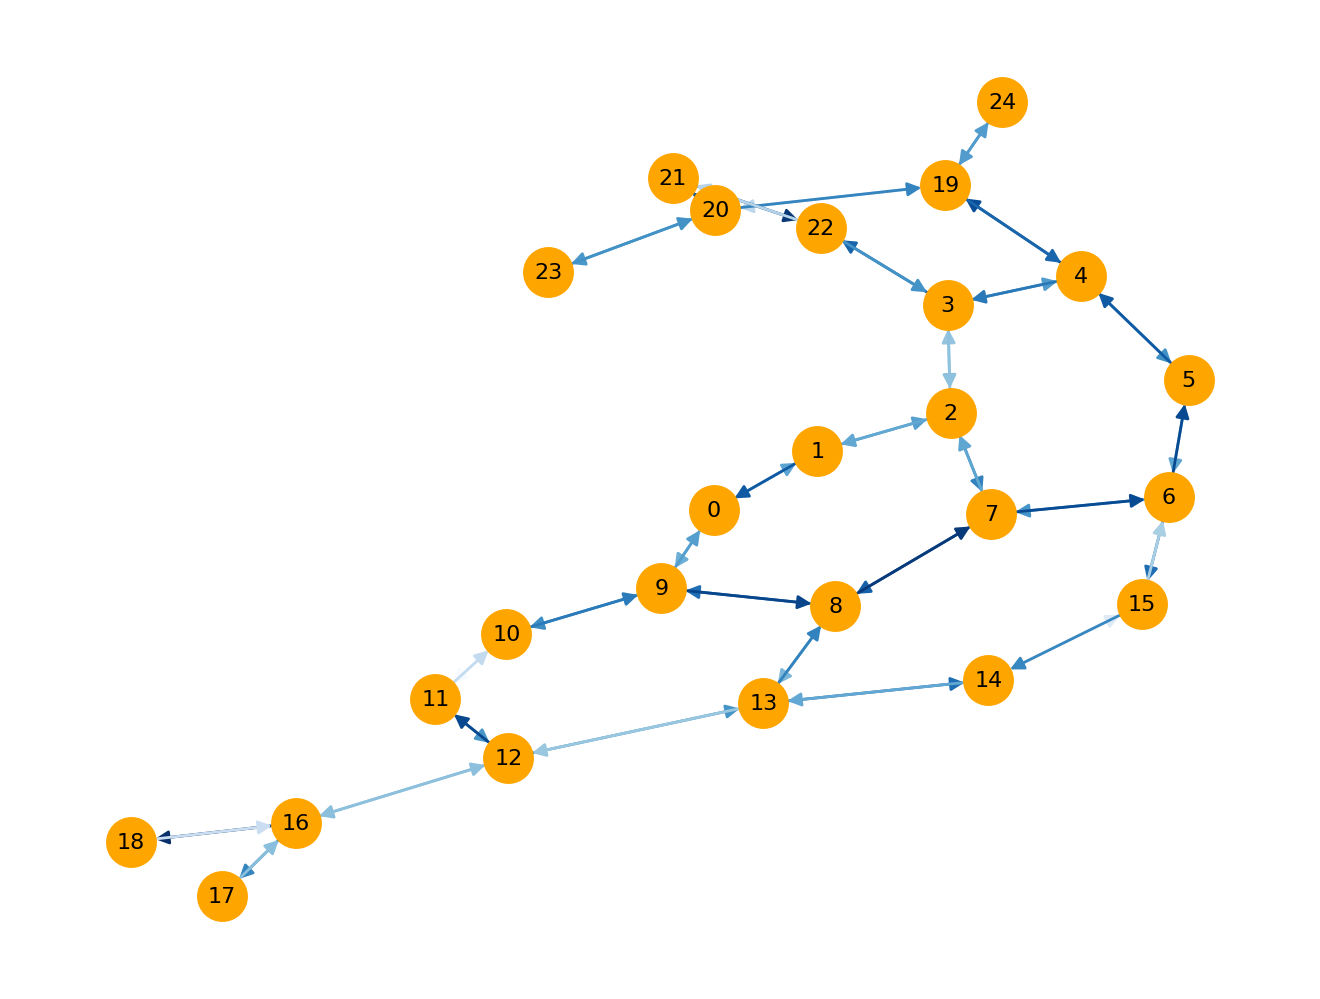

In [37]:
explainer = GNNExplainer(model, epochs=100, num_hops=1)
data = data_preparation.dataset[-1]
batch = torch.zeros(data.x.size(0), dtype=torch.long, device=data.x.device)
feature_mask, edge_mask = explainer.explain_graph(data.x, data.edge_index)
G = to_networkx(data, edge_attrs=['edge_attr'])
edge_mask = edge_mask.detach().cpu().numpy()
edge_mask = (edge_mask - edge_mask.min()) / (edge_mask.max() - edge_mask.min() + 1e-5)
plt.figure(dpi=200)
pos = nx.spring_layout(G)
nx.draw(G, pos, with_labels=True, edge_color=edge_mask, edge_cmap=plt.cm.Blues, node_size=300, font_size=8, node_color='orange')
plt.show()

### **GCN Model with Captum Integration And Test GCN Model**

In [38]:
twitch_data_preparation = DataPreparation(twitch=True, dataset_name='EN')
gcn_model = GCNModel(dim_h=64, dataset=twitch_data_preparation.dataset).to(torch.device('cuda' if torch.cuda.is_available() else 'cpu'))
twitch_data = twitch_data_preparation.data.to(torch.device('cuda' if torch.cuda.is_available() else 'cpu'))
optimizer = torch.optim.Adam(gcn_model.parameters(), lr=0.001, weight_decay=5e-4)

for epoch in range(200):
    gcn_model.train()
    optimizer.zero_grad()
    log_logits = gcn_model(twitch_data.x, twitch_data.edge_index)
    loss = F.nll_loss(log_logits, twitch_data.y)
    loss.backward()
    optimizer.step()

acc = trainer.accuracy(gcn_model(twitch_data.x, twitch_data.edge_index).argmax(dim=1), twitch_data.y)
print(f'Accuracy: {acc*100:.2f}%')

Accuracy: 66.46%
